# PRÁCTICA GUIADA: Árboles de decisión

## Introducción

En este lab practicaremos cómo aplicar árboles de decisión a problemas de regresión y clasificación. En particular, utilizaremos árboles de regresión para predecir el precio mediano de las casas en Boston y para predecir la aceptabilidad de los autos.

## Recursos Adicionales

- [scikit-learn documentación de árboles de decisión](http://scikit-learn.org/stable/modules/tree.html)
- [Gini Vs Entropia](http://www.garysieling.com/blog/sklearn-gini-vs-entropy-criteria)

## 1: Construir un árbol de regresión

#### ¿Cómo construye la computadora un árbol de regresión?

El enfoque ideal sería que la computadora considere todas las particiones posibles del espacio de atributos. Sin embargo esto es computacionalmente inviable, por lo que en su lugar se utiliza un algorítmo voraz (greedy) de **división binaria recursiva:**

- Comenzar en la raíz del árbol.
- Para cada atributo, examinar cada punto de corte posible y elegir el atributo y punto de corte de manera que el árbol resultante de hacer la división tenga el **menor error cuadrático medio (ECM)**.
- Repetir el proceso para las dos ramas resultantes y nuevamente hacer una sola división (en cada rama) para minimizar el ECM.
- Repitir este proceso hasta que se cumpla un criterio de detención.

**¿Cómo sabe cuándo parar?**

1. Podríamos definir un criterio de detención, como la **profundidad máxima** del árbol o **el número mínimo de muestras en la hoja**.
2. También podríamos hacer crecer el árbol grande y luego "podarlo" utilizando algún método de poda como "cost complexity pruning"

> Nota: El método 2 no es soportado por scikit-learn, por lo que aquí vamos a utilizar el método 1.

**¿Como decidir que división es la mejor?**

Una forma de decidir cual es la mejor división es calcular la ganancia en la reduccion del error cuadrático medio, si se aplica la división candidata.

$$
\Delta = ECM(\text{padre}) - \sum_{j \in \text{hijos}}\frac{N_j}{N}ECM(\text{hijo}_j)
$$

El objetivo es buscar la maxima $\Delta$, donde $ECM$ es el Error Cuadrático Medio, $N_j$ es el número de registros en el nodo hijo $j$ y $N$ es el número de registros en el nodo padre.


### 1.a  Realizar un análisis descriptivo del dataset

El set de entrenamiento es el viejo y conocido dataset de Boston. El objetivo es predecir el precio mediano de los condados.   

Instrucciones:

1. Leer los datos con Pandas.
- Explorar los datos ordenándolos o graficándolos.

In [2]:
# Leer los datos con Pandas.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import load_boston
data = load_boston()

X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.DataFrame(data.target, columns=['price'])

In [3]:
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


### 2: Construir un árbol de regresión con scikit-learn

Como puede intuirse, construir un árbol a mano no es tan fácil. Ahora vamos a utilizar scikit-learn para construir un árbol de regresión óptimo. 
Hacer lo siguiente:

- Crear una matriz `X` que contenga los valores de los atributos y un vector `y` que contenga los precios
- Partir los datos en entrenamiento-testeo usando un `random_state`=41 y un `test_size` del 30%
- Importar e inicializar el `DecisionTreeRegressor` de scikit-learn
- Ajustarlo al set de entrenamiento
- Predecir los valores del set de testeo
- Mostrar los valores predichos y reales en un gráfico
- Usar r2_score para juzgar la bondad de la regresión

In [4]:
# partimos en entrenamiento-prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)

In [5]:
# Importar el DecisionTreeRegressor, inicializarlo y ajustarlo al set de entrenamiento
from sklearn.tree import DecisionTreeRegressor
treereg = DecisionTreeRegressor(random_state=1)
treereg.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=1, splitter='best')

In [6]:
# Predecir los precios del set de prueba
preds = treereg.predict(X_test)

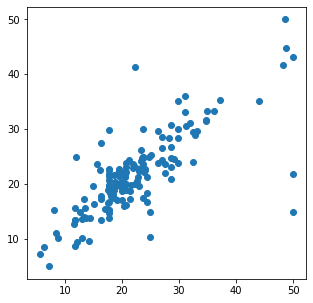

In [7]:
# Mostrar los valores predichos y reales en un gráfico
plt.figure(figsize=(5,5))
plt.scatter(preds, y_test);

In [8]:
# Usar r2_score para juzgar la bondad de la regresión
from sklearn.metrics import r2_score
r2_score(y_test, preds)

0.43278713254133316

El r2 en el set de testeo arroja resultados pobres, pero la misma métrica en el set de testeo arroja resultados perfecto. Esto significa que, como era de esperarse, el árbol está sobre ajustando el set de entrenamiento.

In [9]:
preds_train = treereg.predict(X_train)
r2_score(y_train, preds_train)

1.0

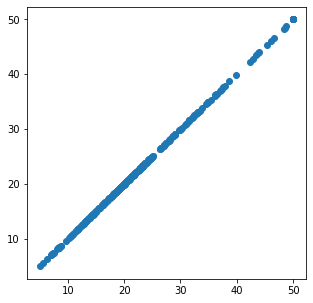

In [10]:
plt.figure(figsize=(5,5))
plt.scatter(preds_train, y_train);

### 2.b Parámetros globales

El `DecisionTreeRegressor` ofrece algunos parámetros globales que se pueden cambiar en la inicialización. Por ejemplo, se pueden establecer los parámetros `max_depth` o `min_samples_leaf` e imponer limitaciones globales en el espacio de las soluciones.

1. Utilizar `cross_val_score` y hacer validación cruzada de 3-fold para encontrar el valor óptimo para `max_depth` (explorar los valores 1 - 10). Tener en cuenta que tendrá que establecer `scoring='neg_mean_squared_error'` como criterio para el score. Establecer siempre `random_state=1`
- Graficar el error como función de `max_depth`

In [11]:
# Usar cross-validation para encontrar el mejor max_depth
from sklearn.model_selection import cross_val_score

Mejor score: 4.715339286515405
Mejor depth: 5


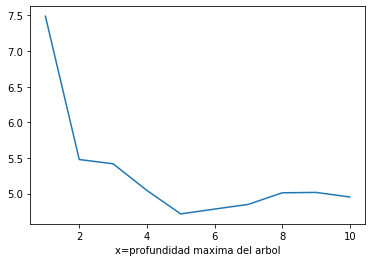

In [11]:
all_scores = []
best_score = -1
best_depth = 0
for i in range(1, 11):
    treereg = DecisionTreeRegressor(max_depth=i, random_state=1)
    scores = cross_val_score(treereg, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
    current_score = np.mean(np.sqrt(-scores))
    # Selecciona el mejor comparando con el mejor hasta ahora.
    if current_score < best_score or best_score == -1:
        best_score = current_score
        best_depth = i
    # Agrega a la lista de scores para graficar
    all_scores.append(current_score)
    
print("Mejor score: %s" % best_score)
print("Mejor depth: %s" % best_depth)

# Graficar el error como función del max_depth
plt.figure()
plt.plot(range(1, 11), all_scores)
plt.xlabel('x=profundidad maxima del arbol');

In [12]:
# Ajustar el modelo utilizando la mejor max_depth
treereg_cv = DecisionTreeRegressor(max_depth=best_depth, random_state=1)
treereg_cv.fit(X_train, y_train)

preds_cv = treereg_cv.predict(X_test)

In [13]:
# Calculamos nuevamente el r2_score para juzgar la bondad de la regresión
r2_score(y_test, preds_cv)

0.47933266463019186

### 2.c Importancia de los atributos

La clase DecisionTreeRegressor expone un atributo llamado `feature_importances_`. Es la contribunción a la reducción en la métrica de error utilizada (en este caso, MSE) a lo largo de todo el árbol. 

1. Comprobar la importancia de cada atributo. ¿Cuál es la más importante? ¿De qué otra forma podríamos visualizar esta importancia de forma más simple?

In [14]:
pd.DataFrame({'atributo':data.feature_names, 'importancia':treereg_cv.feature_importances_}).sort_values('importancia', ascending = False)

,atributo,importancia
5,RM,0.636483
12,LSTAT,0.222324
7,DIS,0.080925
0,CRIM,0.031472
10,PTRATIO,0.007841
6,AGE,0.007571
9,TAX,0.005106
11,B,0.004826
4,NOX,0.003433
2,INDUS,0.000019


### 2.d Visualización del árbol

Seguir el ejemplo de la [documentación](http://scikit-learn.org/stable/modules/tree.html) para visualizar el árbol.  
Podría ser necesario instalar `pydotplus` si aún no lo tiene instalado.

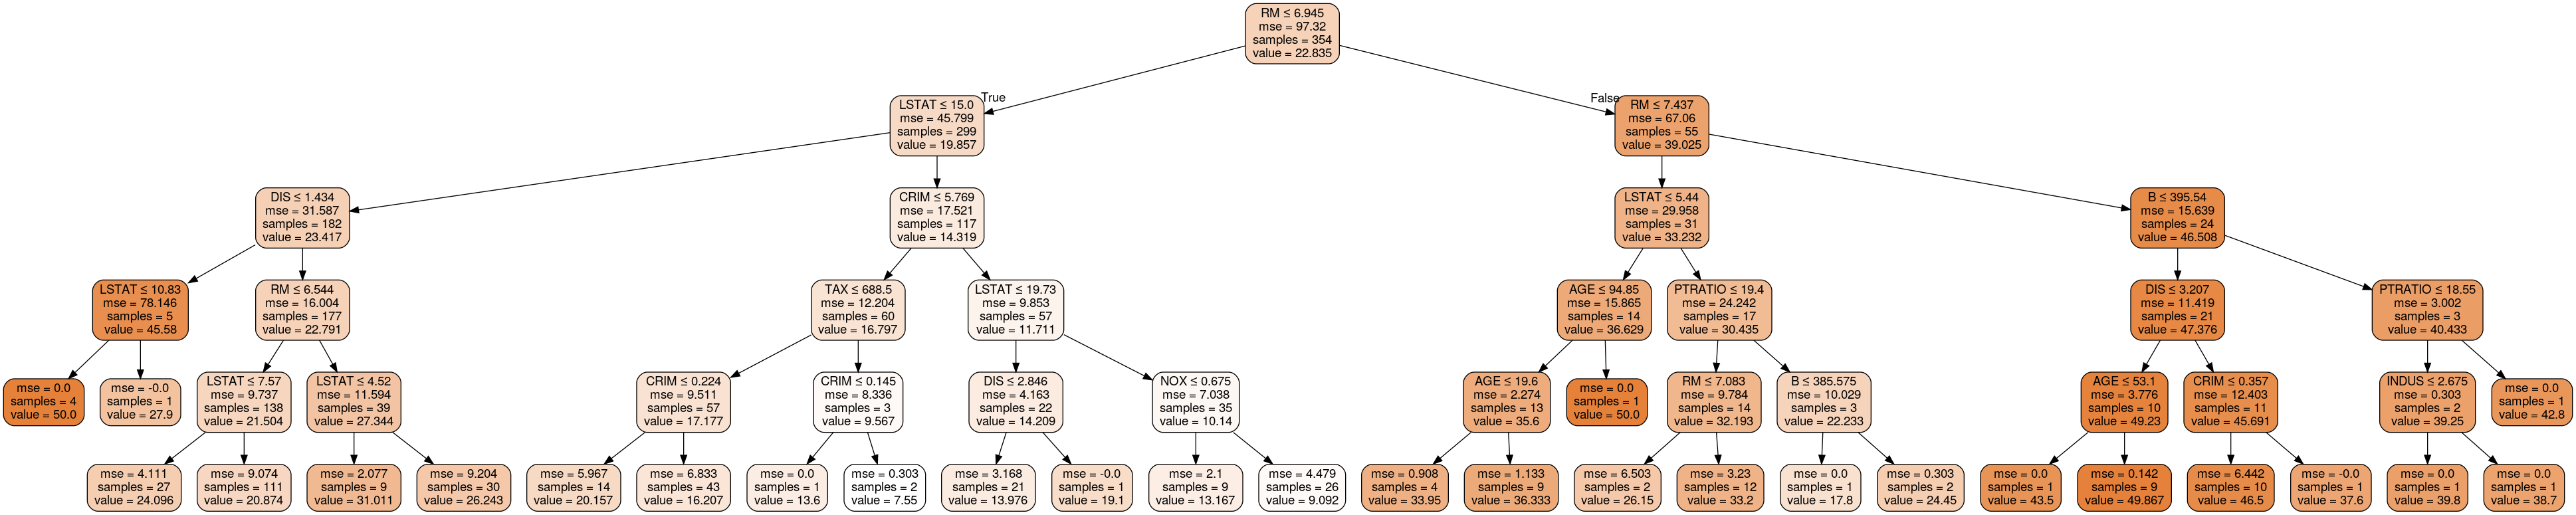

In [15]:
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

dot_data=export_graphviz(treereg_cv, out_file=None,  
                feature_names=data.feature_names,  
                filled=True, rounded=True,  
                special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())  

#### Interpretando el diagrama de un árbol

¿Cómo leer este árbol de decisión?

**Nodos internos:**

- `samples` es el número de observaciones en el nodo antes de ser dividido. (verificar que es la suma del valor `samples` de sus nodos hijos)
- `mse` es el error cuadrático medio calculado comparando los valores observados de respuesta en ese nodo con el valor medio de respuesta en ese nodo
- La primera línea es la condición utilizada para dividir ese nodo (ir a la izquierda si es verdadera, ir a la derecha si es falsa)

**Hojas:**

- `samples` es el número de observaciones en el nodo
- `value` es el valor medio de respuesta en ese nodo
- `mse` es el error cuadrático medio calculado comparando los valores observados de respuesta en ese nodo frente a `value`

## 3 Árboles de clasificación

Los árboles de clasificación son muy similares a los árboles de regresión. Aquí hay una comparación rápida:

| árboles de regresión | árboles de clasificación |
|---|---|
| predicen respuestas continuas | predicen respuestas categóricas |
| predice utilizando la respuesta media en cada hoja | predice usando la clase mas común en cada hoja |
| Se eligen las divisiones para minimizar el ECM | Se eligen las divisiones para minimizar un criterio diferente (discutido más adelante) |



### 3.a Construyendo un árbol de clasificación con scikit-learn
Construiremos un árbol de clasificación usando el dataset de autos.

- Leer los datos con Pandas.
- Comprobar si hay valores vacíos
- Encodear todos los atributos categóricos como booleanos usando `pd.get_dummies`
- Encodear las etiquetas usando `LabelEncoder`
- Dividir X e y con train_test_split así:
        train_test_split(X, y, test_size=0.3, random_state=42)
- Ajustar un árbol de clasificación con `max_depth=3`
- Visualizar el árbol usando graphviz
- Calcular la importancia de los atributos
- Calcular y mostrar la matriz de confusión
- Sacar la restricción de `max_depth=3` y ver si la clasificación mejora

In [22]:
df = pd.read_csv('cars.csv')
df.head(10)

,buying,maint,doors,persons,lug_boot,safety,acceptability
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
5,vhigh,vhigh,2,2,med,high,unacc
6,vhigh,vhigh,2,2,big,low,unacc
7,vhigh,vhigh,2,2,big,med,unacc
8,vhigh,vhigh,2,2,big,high,unacc
9,vhigh,vhigh,2,4,small,low,unacc


In [23]:
# Buscar si hay valores vacíos
df.isnull().sum()

buying           0
maint            0
doors            0
persons          0
lug_boot         0
safety           0
acceptability    0
dtype: int64

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
buying           1728 non-null object
maint            1728 non-null object
doors            1728 non-null object
persons          1728 non-null object
lug_boot         1728 non-null object
safety           1728 non-null object
acceptability    1728 non-null object
dtypes: object(7)
memory usage: 94.6+ KB


In [25]:
# Encodear todos los atributos categóricos como booleanos usando pd.get_dummies
X = pd.get_dummies(df.drop('acceptability', axis=1))
atributos = X.columns

# Encodear las etiquetas usando LabelEncoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(df['acceptability'])

# Dividir X e y con train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [26]:
le.classes_

array(['acc', 'good', 'unacc', 'vgood'], dtype=object)

In [27]:
# Ajustar un árbol de clasificación con max_depth=3
from sklearn.tree import DecisionTreeClassifier
treeclf = DecisionTreeClassifier(max_depth=3, random_state=1)
treeclf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

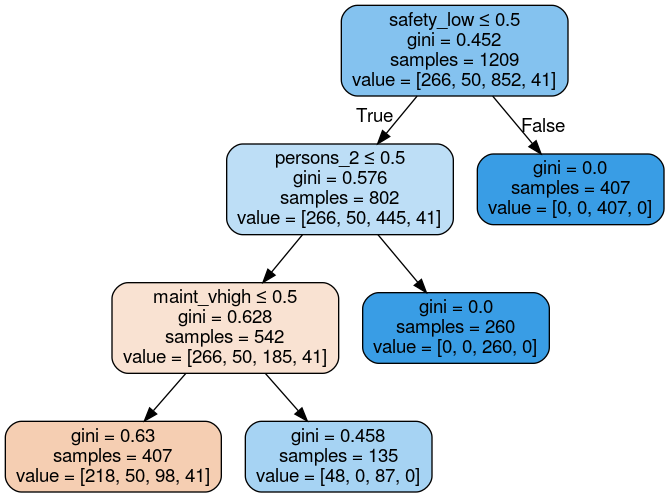

In [28]:
# Visualizar el árbol usando graphviz
dot_data = export_graphviz(treeclf, out_file=None,  
                feature_names=atributos,  
                filled=True, rounded=True,  
                special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [29]:
# Calcular la importancia de los atributos
pd.DataFrame({'Atributo':atributos,
              'importancia':treeclf.feature_importances_}).sort_values('importancia',
                                                                      ascending=False).head()

,Atributo,importancia
12,persons_2,0.530079
19,safety_low,0.371993
7,maint_vhigh,0.097928
0,buying_high,0.000000
11,doors_5more,0.000000


In [30]:
# Calcular y mostrar la matriz de confusión
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(y_test, treeclf.predict(X_test))
predicted_cols = ['pred_'+c for c in le.classes_]
pd.DataFrame(conf, index = le.classes_, columns = predicted_cols)

,pred_acc,pred_good,pred_unacc,pred_vgood
acc,94,0,24,0
good,19,0,0,0
unacc,32,0,326,0
vgood,24,0,0,0


In [31]:
# Sacar la restricción de max_depth=3 y ver si la clasificación mejora
treeclf = DecisionTreeClassifier(random_state=1)
treeclf.fit(X_train, y_train)
y_pred = treeclf.predict(X_test)
conf = confusion_matrix(y_test, y_pred)
predicted_cols = ['pred_'+c for c in le.classes_]
pd.DataFrame(conf, index = le.classes_, columns = predicted_cols)

,pred_acc,pred_good,pred_unacc,pred_vgood
acc,105,4,6,3
good,1,17,0,1
unacc,3,0,355,0
vgood,3,2,0,19


## Extra

Visualizar el último árbol. ¿Podés interpretarlo? ¿Qué te enseña esto acerca de la interpretación del árbol de decisión?

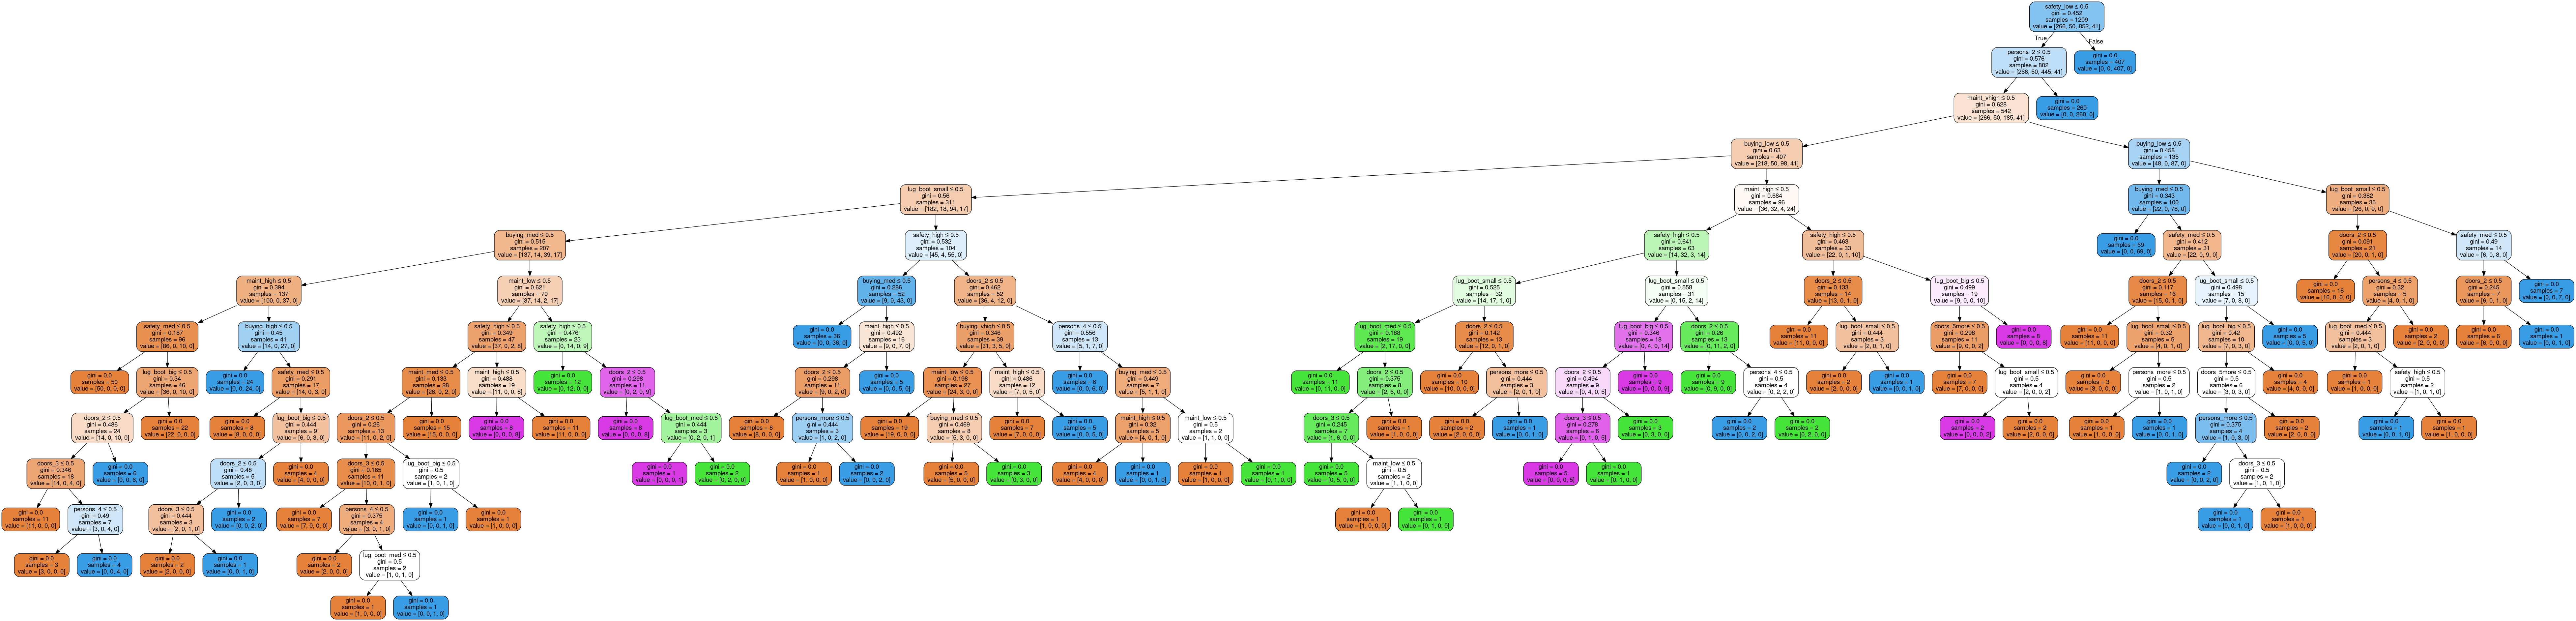

In [32]:
dot_data = export_graphviz(treeclf, out_file=None,  
                feature_names=atributos,  
                filled=True, rounded=True,  
                special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())  